# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.198480,False,-1.845346
1,0.903835,True,5.670382
2,-0.765031,False,-0.498389
3,-0.051720,False,-1.400600
4,0.139075,False,0.580501
...,...,...,...
995,-1.990836,False,-2.737242
996,0.329670,False,-0.333426
997,2.934460,True,7.790200
998,1.388273,True,5.067398


<Axes: xlabel='v0'>

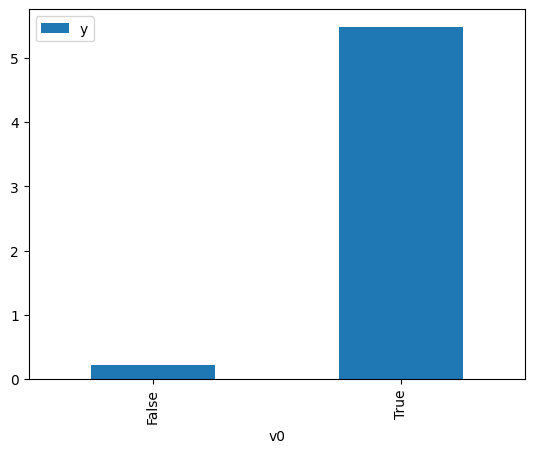

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

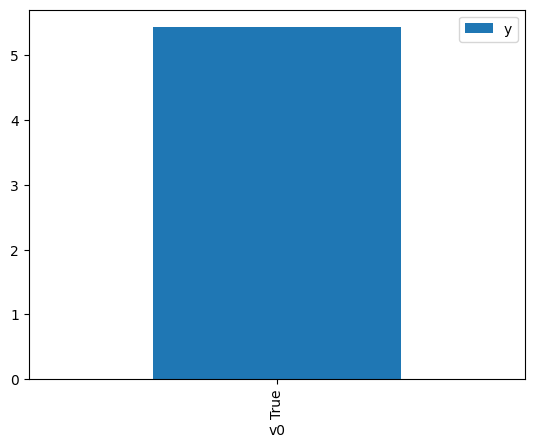

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.702047,False,0.876622,0.267046,3.744672
1,1.271610,False,1.001183,0.135510,7.379551
2,0.418509,False,1.266033,0.356684,2.803603
3,-1.164456,False,-2.301809,0.852500,1.173021
4,0.492995,False,0.187609,0.331793,3.013931
...,...,...,...,...,...
995,0.897067,False,1.856628,0.214425,4.663637
996,-1.470838,False,-3.333185,0.900970,1.109915
997,1.344208,False,1.185349,0.123402,8.103614
998,1.129388,False,0.784521,0.162127,6.168016


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.410460,True,1.603712,0.107299,9.319782
1,-0.038114,True,5.906625,0.478413,2.090245
2,-0.302803,True,6.007793,0.382638,2.613436
3,-0.453392,True,3.987671,0.331510,3.016505
4,0.815922,True,7.202273,0.764641,1.307804
...,...,...,...,...,...
995,1.772375,True,7.903478,0.930517,1.074672
996,-0.608199,True,3.890855,0.282801,3.536057
997,-0.105215,True,5.379397,0.453691,2.204143
998,-0.479767,True,5.664884,0.322912,3.096822


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9963.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:08:50   Log-Likelihood:                         -1428.3
No. Observations:                1000   AIC:                                      2861.
Df Residuals:                     998   BIC:                                      2870.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1304      0.037     30.887      0.000       1.059       1.202
x2             5.1402      0.050    103.204      0.000       5.042       5.238
==============================================================================
Omnibus:                        1.784   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.410   Jarque-Bera (JB):                1.764
Skew:                          -0.008   Prob(JB):                        0.414
Kurtosis:                       3.205   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""